In [1]:
 !pip install mlxtend
 !pip install onnxmltools
 !pip install onnxruntime
 !pip install skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.5/352.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import pandas as pd
import sklearn
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import matplotlib.pyplot as plt

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


from sklearn.metrics import r2_score

In [4]:
import xgboost as xgb

In [5]:

import onnxruntime as rt
import onnxmltools

from skl2onnx.common.data_types import FloatTensorType

In [6]:
batch_size    = 16
learning_rate = 0.005
N_Epochs      = 100

epsilon = 0.0001

In [7]:

path_data = '/content/drive/MyDrive/Colab Notebooks/taxi_trip_pricing.csv'

taxi_raw_data = pd.read_csv( path_data, delimiter="," )

In [8]:

taxi_raw_data

,Trip_Distance_km,Time,Day,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,36.87,Evening,Weekend,1,High,Clear,2.70,1.21,0.15,37.27,52.9032
2,8.64,Afternoon,Weekend,2,Medium,Clear,2.55,1.71,0.48,89.33,60.2028
3,41.79,Night,Weekend,3,High,Clear,4.60,1.77,0.11,86.95,88.1328
4,9.91,Evening,Weekday,2,High,Clear,2.32,1.26,0.34,41.72,28.9914
...,...,...,...,...,...,...,...,...,...,...,...
557,40.17,Evening,Weekday,3,Low,Clear,3.81,0.66,0.42,62.66,56.6394
558,14.34,Afternoon,Weekday,1,Medium,Clear,3.23,1.01,0.29,45.07,30.7837
559,18.69,Evening,Weekday,3,Medium,Clear,4.90,1.79,0.17,79.41,51.8548
560,5.49,Afternoon,Weekend,4,Medium,Clear,2.39,0.62,0.49,58.39,34.4049


# **Converting Strings to Integers in Dataset**

In [9]:
import pandas as pd
import json


taxi_raw_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/taxi_trip_pricing.csv")


categorical_cols = ['Time', 'Day', 'Traffic_Conditions', 'Weather']


mappings = {}


for col in categorical_cols:
    unique_values = taxi_raw_data[col].unique()
    mapping_dict = {val: idx for idx, val in enumerate(unique_values)}


    taxi_raw_data[col] = taxi_raw_data[col].map(mapping_dict)


    mappings[col] = mapping_dict


print("Converted DataFrame:\n")
print(taxi_raw_data.head())


print("\nMappings used for conversion:")
for col, mapping in mappings.items():
    print(f"{col}: {mapping}")


Converted DataFrame:

   Trip_Distance_km  Time  Day  Passenger_Count  Traffic_Conditions  Weather  \
0             19.35     0    0                3                   0        0   
1             36.87     1    1                1                   1        0   
2              8.64     2    1                2                   2        0   
3             41.79     3    1                3                   1        0   
4              9.91     1    0                2                   1        0   

   Base_Fare  Per_Km_Rate  Per_Minute_Rate  Trip_Duration_Minutes  Trip_Price  
0       3.56         0.80             0.32                  53.82     36.2624  
1       2.70         1.21             0.15                  37.27     52.9032  
2       2.55         1.71             0.48                  89.33     60.2028  
3       4.60         1.77             0.11                  86.95     88.1328  
4       2.32         1.26             0.34                  41.72     28.9914  

Mappings used fo

In [10]:
taxi_raw_data

,Trip_Distance_km,Time,Day,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,0,0,3,0,0,3.56,0.80,0.32,53.82,36.2624
1,36.87,1,1,1,1,0,2.70,1.21,0.15,37.27,52.9032
2,8.64,2,1,2,2,0,2.55,1.71,0.48,89.33,60.2028
3,41.79,3,1,3,1,0,4.60,1.77,0.11,86.95,88.1328
4,9.91,1,0,2,1,0,2.32,1.26,0.34,41.72,28.9914
...,...,...,...,...,...,...,...,...,...,...,...
557,40.17,1,0,3,0,0,3.81,0.66,0.42,62.66,56.6394
558,14.34,2,0,1,2,0,3.23,1.01,0.29,45.07,30.7837
559,18.69,1,0,3,2,0,4.90,1.79,0.17,79.41,51.8548
560,5.49,2,1,4,2,0,2.39,0.62,0.49,58.39,34.4049


In [11]:
headers_list = taxi_raw_data.columns.values.tolist()

headers_list

['Trip_Distance_km',
 'Time',
 'Day',
 'Passenger_Count',
 'Traffic_Conditions',
 'Weather',
 'Base_Fare',
 'Per_Km_Rate',
 'Per_Minute_Rate',
 'Trip_Duration_Minutes',
 'Trip_Price']


# **Data Analysis**
*   Correlation matrix







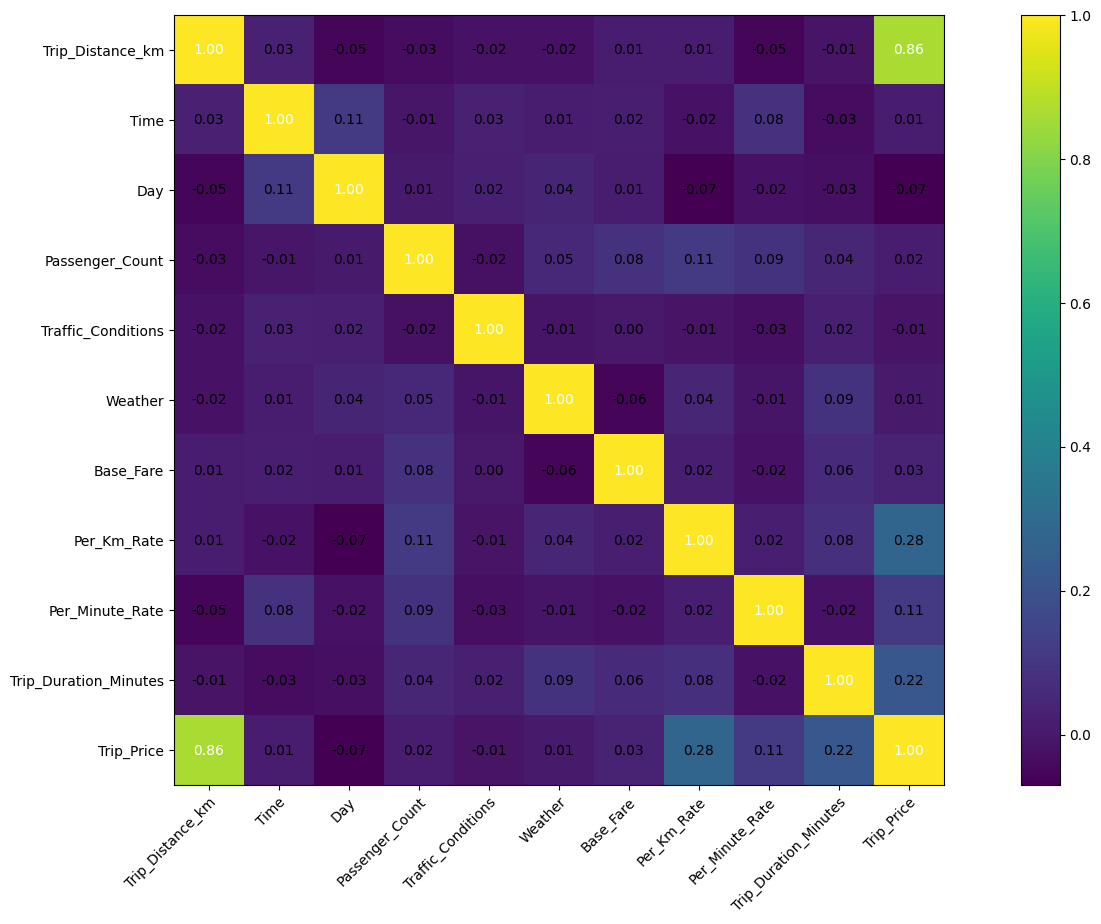

In [12]:
cm = np.corrcoef(   taxi_raw_data[headers_list].values.T   )
hm = heatmap(cm, row_names=headers_list, column_names=headers_list, figsize=(20,10))
plt.show()

In [13]:
taxi_raw_data_np = taxi_raw_data.to_numpy()

In [14]:
taxi_raw_data_np

array([[ 19.35  ,   0.    ,   0.    , ...,   0.32  ,  53.82  ,  36.2624],
       [ 36.87  ,   1.    ,   1.    , ...,   0.15  ,  37.27  ,  52.9032],
       [  8.64  ,   2.    ,   1.    , ...,   0.48  ,  89.33  ,  60.2028],
       ...,
       [ 18.69  ,   1.    ,   0.    , ...,   0.17  ,  79.41  ,  51.8548],
       [  5.49  ,   2.    ,   1.    , ...,   0.49  ,  58.39  ,  34.4049],
       [ 47.56  ,   0.    ,   0.    , ...,   0.17  , 114.94  ,  61.209 ]])

In [15]:
taxi_raw_data_np.shape

(562, 11)

In [16]:
X = taxi_raw_data_np[:, :-1]


y = taxi_raw_data_np[:, 10:11]

In [17]:
y

array([[ 36.2624   ],
       [ 52.9032   ],
       [ 60.2028   ],
       [ 88.1328   ],
       [ 28.9914   ],
       [ 27.4415   ],
       [ 56.716    ],
       [ 69.0049   ],
       [ 44.7782   ],
       [201.8695092],
       [ 39.2366   ],
       [280.8773016],
       [ 24.2608   ],
       [ 58.8121   ],
       [ 20.7765   ],
       [ 61.5552   ],
       [ 54.1018   ],
       [ 40.9225   ],
       [ 20.791    ],
       [ 57.0482   ],
       [ 42.9921   ],
       [ 30.9982   ],
       [ 44.844    ],
       [ 44.1197   ],
       [ 20.1596   ],
       [ 57.0766   ],
       [ 41.9343   ],
       [ 72.2695   ],
       [ 99.8989   ],
       [ 37.1504   ],
       [ 78.715    ],
       [ 59.181    ],
       [ 69.6575   ],
       [320.9586636],
       [ 61.4595   ],
       [ 68.3748   ],
       [ 71.2142   ],
       [ 69.5281   ],
       [ 11.3358   ],
       [ 36.4388   ],
       [104.2421   ],
       [ 16.9284   ],
       [ 94.2463   ],
       [ 87.6076   ],
       [ 42.8661   ],
       [ 1

In [18]:
print(X.shape)

print(y.shape)

(562, 10)
(562, 1)


In [19]:
random_seed = int( random.random() * 100 )

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(449, 10)
(113, 10)
(449, 1)
(113, 1)


In [22]:
y_test.dtype

dtype('float64')

# **Fix in case float64 error**

In [23]:
X_train = X_train.astype(  np.float32  )
X_test  = X_test.astype(   np.float32  )
y_train = y_train.astype(  np.float32  )
y_test  = y_test.astype(   np.float32  )

In [24]:
X_train_tr = torch.from_numpy(X_train)
X_test_tr  = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr  = torch.from_numpy(y_test)

# **Normalization**

In [25]:
x_means      = X_train_tr.mean(0, keepdim=True )

x_deviations = X_train_tr.std( 0, keepdim=True) + epsilon

In [26]:
x_means

tensor([[27.9126,  1.3563,  0.3296,  2.5212,  0.9978,  0.3942,  3.5150,  1.2181,
          0.2933, 60.5683]])

In [27]:
x_deviations

tensor([[19.9005,  0.9900,  0.4707,  1.1261,  0.9077,  0.6291,  0.8678,  0.4412,
          0.1155, 32.4976]])


# **Create the DataLoader**

In [28]:
train_ds = TensorDataset( X_train_tr, y_train_tr  )

In [29]:
train_dl = DataLoader( train_ds, batch_size, shuffle=True  )

In [30]:
train_dl

# **Neural Network Architectures**

In [31]:
## Linear Regression

class LinRegNet(nn.Module):

    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(10, 1)


    def forward(self, x):

        x = (x - self.x_means) / self.x_deviations

        y_pred = self.linear1(x)

        return y_pred


In [32]:
## MLP

class MLP_Net(nn.Module):

    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(10, 8)
        self.act1    = nn.Sigmoid()
        self.linear2 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):

        x = (x - self.x_means) / self.x_deviations

        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        y_pred = self.linear2(x)

        return y_pred

In [54]:
## Deep Learning with 2 hidden layers

class DL_Net(nn.Module):

    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(10, 10)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(6, 1)
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):

        x = (x - self.x_means) / self.x_deviations

        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)

        y_pred = self.linear3(x)


        return y_pred

In [34]:
## Linear plus Nonlinear
## f1 + f2

class LinearPlusNonLinear_Net(nn.Module):

    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations


        self.f1_linear1 = nn.Linear(10, 1)


        self.f2_linear1 = nn.Linear(10, 14)
        self.f2_act1    = nn.Sigmoid()
        self.f2_linear2 = nn.Linear(14, 1)



    def forward(self, x):

        x = (x - self.x_means) / self.x_deviations


        f1 = self.f1_linear1(x)

        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_linear2(f2)

        y_pred = f1 + f2


        return y_pred

# **Training Loop**

In [35]:
def training_loop( N_Epochs, model, loss_fn, opt  ):

    for epoch in range(N_Epochs):
        for xb, yb in train_dl:

            y_pred = model(xb)
            loss   = loss_fn(y_pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

        if epoch % 20 == 0:
            print(epoch, "loss=", loss)

In [55]:
## model = LinRegNet( x_means, x_deviations  )
model = LinearPlusNonLinear_Net( x_means, x_deviations  )

opt     = torch.optim.Adam(    model.parameters(), lr=learning_rate )
loss_fn = F.mse_loss

training_loop(  N_Epochs, model, loss_fn, opt  )

0 loss= tensor(488.0611, grad_fn=<MseLossBackward0>)
20 loss= tensor(122.6736, grad_fn=<MseLossBackward0>)
40 loss= tensor(9.1177, grad_fn=<MseLossBackward0>)
60 loss= tensor(110.3423, grad_fn=<MseLossBackward0>)
80 loss= tensor(18.4302, grad_fn=<MseLossBackward0>)


# **Evaluate Model**

In [37]:
y_pred_test = model( X_test_tr )

In [38]:
y_pred_test.shape

torch.Size([113, 1])

In [53]:
print( "Testing R**2: ", r2_score(  y_test_tr.numpy(),  y_pred_test.detach().numpy()     )  )

Testing R**2:  0.5166324377059937


In [40]:
y_pred_test.shape

torch.Size([113, 1])

In [41]:
y_test_tr.shape

torch.Size([113, 1])

In [42]:
len(X_test_tr)

113

In [43]:
list_preds = []
list_reals = []

for i in range(len(X_test_tr)):
    print("************************************")
    print("pred, real")
    np_real =   y_test_tr[i].detach().numpy()
    np_pred = y_pred_test[i].detach().numpy()
    print(( np_pred  , np_real))
    list_preds.append(np_pred[0])
    list_reals.append(np_real[0])

************************************
pred, real
(array([91.177086], dtype=float32), array([88.1462], dtype=float32))
************************************
pred, real
(array([31.661713], dtype=float32), array([30.4015], dtype=float32))
************************************
pred, real
(array([42.26693], dtype=float32), array([45.1726], dtype=float32))
************************************
pred, real
(array([54.11417], dtype=float32), array([57.0766], dtype=float32))
************************************
pred, real
(array([54.631313], dtype=float32), array([54.1212], dtype=float32))
************************************
pred, real
(array([25.421339], dtype=float32), array([23.1248], dtype=float32))
************************************
pred, real
(array([47.943184], dtype=float32), array([45.2346], dtype=float32))
************************************
pred, real
(array([48.075027], dtype=float32), array([43.6034], dtype=float32))
************************************
pred, real
(array([38.397087]

# **Deploy PyTorch Model**

In [56]:

model.eval()

dummy_input = torch.randn(1, 10)

input_names  = ["input1"]
output_names = ["output1"]

torch.onnx.export(
        model,
        dummy_input,
        "LinearPlusNonLinear_Net_TaxiData.onnx",
        verbose=False,
        input_names = input_names,
        output_names = output_names

)

/tmp/ipython-input-3539570270.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


# **XGBoost**

In [60]:
regressor = xgb.XGBRegressor(

        n_estimators=100,
        reg_lambda=1,
        gamma=0,
        max_depth=3,
        base_score=0.5
)

In [46]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [47]:
y_pred = regressor.predict(X_test)

In [48]:
y_pred.shape

(113,)

In [49]:
y_pred

array([ 86.87644  ,  37.83107  ,  40.869175 ,  56.876965 ,  48.842262 ,
        24.919024 ,  46.55396  ,  47.002155 ,  41.14574  ,  50.85962  ,
        38.970394 ,  46.102177 ,  70.917885 ,  36.92772  ,  68.442604 ,
        34.698784 ,  53.935677 ,  50.76223  ,  30.974823 ,  81.01636  ,
        54.350777 ,  33.183426 ,  42.52599  ,  70.26329  ,  65.14541  ,
        82.73017  ,  57.873062 ,  47.212048 ,  28.362097 ,  38.229145 ,
        59.931625 ,  90.14723  ,  40.645645 , 244.46149  ,  72.934685 ,
        30.445658 ,  33.559406 ,  43.42987  ,  37.52759  ,  97.45378  ,
        69.46426  ,  32.88084  ,  35.658764 ,  37.773193 ,  36.674034 ,
        36.188038 ,  53.95242  ,  38.44712  ,  15.346125 ,  48.316177 ,
        33.010067 , 261.4938   ,  36.746128 ,  50.301655 ,  59.688175 ,
        68.39186  ,  62.90759  ,  46.71509  ,   6.7690487,  18.373505 ,
        31.040644 , 124.20731  ,  35.12664  ,  29.95147  ,  53.686295 ,
        46.367313 ,  43.42942  ,  27.091475 ,  61.876133 , 225.6

In [50]:
r2_score(y_test, y_pred)

0.9183942079544067

# **Deploy XGBoost Model**

In [51]:
initial_types = [(
          'float_input',
          FloatTensorType(  [None, 10 ]  )

)]

In [62]:
onnx_model = onnxmltools.convert_xgboost(regressor, initial_types=initial_types)

onnxmltools.utils.save_model(onnx_model, 'xgboost_TaxiData.onnx')